## 데이터 전처리

In [49]:
# 1. 결측치 제거 및 대체
# 2. 이상치 확인(피쳐 엔지니어링 후)
# 3. 타겟 라벨링

In [40]:
# L.RD, L.Vac, R.RD, R.Vac : 타겟
# 그 외 : 피쳐 

In [55]:
# 한글, 음수 시각화 설정

#시각화 패키지
import matplotlib.pyplot as plt

#시각화에서 한글을 사용하기 위한 설정
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    
#시각화에서 음수를 표현하기 위한 설정
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False 

import warnings
warnings.filterwarnings('ignore')

In [66]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN


In [41]:
factory_df = pd.read_csv('../data/factory_glass_2016.csv', encoding= 'cp949')
factory_df.info() # 8145 data, 841 columns
len(factory_df.index)
print()

# 시계열 데이터 인덱스
factory_df['dat...date.name.'] = pd.to_datetime(factory_df['dat...date.name.'])
factory_df = factory_df.set_index('dat...date.name.', drop= True)
factory_df.info() # 8145 data, 840 columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8145 entries, 0 to 8144
Columns: 841 entries, dat...date.name. to R.Vac
dtypes: float64(834), int64(6), object(1)
memory usage: 52.3+ MB

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8145 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 840 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to R.Vac
dtypes: float64(834), int64(6)
memory usage: 52.3 MB


## 1.  결측치 제거

- 결측행 제거 및 보간

In [42]:
# 각 컬럼의 결측치 수 확인
# 1) 결측치 열 삭제 
missing_values_columns = factory_df.isnull().sum() 
missing_values_columns[missing_values_columns > 8000] # 7개의 열 - 결측치 8145 전부

drop_df = factory_df.drop(missing_values_columns[missing_values_columns == 8145].index, axis= 1) 
drop_df.info() # column 840 > 833
print() 

missing_values_columns = drop_df.isnull().sum()
print(missing_values_columns[missing_values_columns > 0]) # 127개의 열열 결측치 존재

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8145 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 833 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to R.Vac
dtypes: float64(827), int64(6)
memory usage: 51.8 MB

Ribbon.Speed                       1
LOWER.C1..Z165.TMP.1TIC42254.PV    1
LOWER.C2..Z179.TMP.1TIC42354.PV    1
LOWER.C3..Z193TMP.1TIC42454.PV     1
LOWER.C4..Z207.TMP.1TIC42554.PV    1
                                  ..
S_C1_C2_L_R                        1
S_C2_C3_L_L                        1
S_C2_C3_L_R                        1
S_C3_C4_L_L                        1
S_C3_C4_L_R                        1
Length: 127, dtype: int64


In [43]:
# 각 인덱스의 결측치 수 확인
# 2) 결측치 행 삭제 및 대체
missing_values_rows = drop_df.isnull().sum(axis= 1)
print(missing_values_rows[missing_values_rows > 0]) # 3754 index : 1, 6310 index : 39, 8044 index : 87 
# -> 6310, 8044 index 삭제
# -> 3754 index 보간법으로 대체
print()

# 행 삭제
drop_df = drop_df.drop(missing_values_rows[missing_values_rows > 0].index[-2:], axis= 0)
drop_df.info() 
print()

# 행 대체 - 시계열 데이터의 경우 선형 보간법 혹은 시간 기반 보간법
missing_col = drop_df.isnull().sum()
missing_col[missing_col > 0] # ribbon.speed
missing_col_name = missing_col[missing_col > 0].index[0]
drop_df[missing_col_name] = drop_df[missing_col_name].interpolate(method= 'time')
print()

# 행 삭제, 보간 적용 확인
missing_values_rows = drop_df.isnull().sum(axis= 1)
print(missing_values_rows[missing_values_rows > 0]) # 없는 것 확인

# 보간법 - imputer
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy = 'median')

dat...date.name.
2016-06-24 04:00:00     1
2016-10-13 09:00:00    39
2016-12-27 17:00:00    87
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 833 entries, LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101 to R.Vac
dtypes: float64(827), int64(6)
memory usage: 51.8 MB


Series([], dtype: int64)


In [ ]:
drop_df.to_csv('../data/preprocessed_df.csv', index= True)

## 2. 이상치 확인

In [44]:
# IQR로 확인
drop_df.describe()

,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,...,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,...,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,0.000936,0.000890,0.000907,0.000807,0.000948,0.000795,0.000948,0.000773,0.000949,0.000773,...,2.216505,0.786197,3.572821,3.719458,3.354256,3.572821,0.018044,0.019171,0.024838,0.008720
std,1.000156,1.000194,1.000180,1.000257,1.000145,1.000266,1.000145,1.000282,1.000145,1.000282,...,3.734319,1.384937,4.741084,6.002389,5.468244,4.741084,0.045043,0.031836,0.047642,0.015835
min,-1.772682,-1.713219,-1.734851,-2.736126,-1.636293,-2.716038,-1.636293,-2.679576,-1.824581,-2.679576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.846817,-0.804910,-0.820307,-0.730496,-0.857942,-0.719593,-0.857942,-0.699527,-0.858236,-0.699527,...,0.000000,0.000000,0.980000,0.930000,0.000000,0.980000,0.000000,0.000000,0.000000,0.000000
50%,-0.383884,-0.350755,-0.363035,-0.587236,-0.390932,-0.576990,-0.390932,-0.699527,-0.375063,-0.699527,...,1.000000,0.000000,2.170000,1.980000,1.740000,2.170000,0.009000,0.010000,0.010000,0.000000
75%,1.004913,1.011709,1.008781,0.988616,1.010099,0.991645,1.010099,0.997658,1.074454,0.997658,...,3.000000,1.000000,4.425000,4.300000,4.250000,4.425000,0.020000,0.022000,0.029000,0.011000
max,2.548022,2.525557,2.533021,2.421208,2.411130,2.417677,2.411130,2.270547,2.523972,2.270547,...,55.000000,18.000000,53.330000,88.640000,70.270000,53.330000,0.841000,0.400000,0.676000,0.173000


In [45]:
def detect_outliers(df) :
  
  outlier_indices = {}
  
  for col in factory_df.select_dtypes(include= np.number).columns :
    q1 = factory_df[col].quantile(0.25)
    q3 = factory_df[col].quantile(0.75)
    IQR = q3 - q1
    
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    
    outlier_indices[col] = factory_df[(factory_df[col] < lower_bound) | (factory_df[col] > upper_bound)].index.tolist()
    
  return outlier_indices
  
outliers = detect_outliers(drop_df)


In [46]:
outlier_columns = []
for col, outlier_list in outliers.items() :
  if len(outlier_list) > 0 :
    outlier_columns.append(col)

print(outlier_columns)
print(len(outlier_columns)) # 680개 > 피쳐 엔지니어링 후 이상치 재확인확인

['X1WOS45101_PV', 'X1WOS45102_PV', 'X1WOS45103_PV', 'X1WOS45104_PV', 'X1WOS45105_PV', 'X1WOS45106_PV', 'X1WOS45107_PV', 'X1WOS45108_PV', 'X1WOS45109_PV', 'X1WOS45110_PV', 'DCS_Offset_RPM_M11.1WOS45111_PV', 'DCS_Offset_RPM_M12.1WOS45112_PV', 'DCS_Offset_RPM_M15.1WOS45115_PV', 'DCS_Offset_RPM_M16.1WOS45116_PV', 'DCS_Offset_RPM_M17.1WOS45117_PV', 'DCS_Offset_RPM_M18.1WOS45118_PV', 'DCS_Offset_RPM_M19.1WOS45119_PV', 'N2.TO.EA1313A.1FI33503A_PV', 'ROOF.HEATING.Zone.1.1JIC31101.PV', 'ROOF.HEATING.Zone.2.1JIC31102.PV', 'ROOF.HEATING.Zone.3.1JIC31103.PV', 'ROOF.HEATING.Zone.4.1JIC31104.PV', 'ROOF.HEATING.Zone.7.1JIC31107.PV', 'ROOF.HEATING.Zone.8.1JIC31108.PV', 'ROOF.HEATING.Zone.9.1JIC31109.PV', 'ATM.FLOW.SECT.6.N2.H2.1FI33410.PV', 'ATM.FLOW.SECT.7.N2.H2.1FI33412.PV', 'ATM.FLOW.SECT.8.N2.H2.1FI33414.PV', 'ATM.FLOW.SECT.9.N2.1FIC33415.PV', 'ATM.FLOW.SECT.9.N2.H2.1FIC33416.PV', 'ATM.FLOW.SECT.10.N2.H2.1FIC33418.PV', 'SEC11.N2.1FIC33425.PV', 'SEC11.N2.H2.9..1FIC33426.PV', 'Ribbon.Speed', 'Gross.

## 3. 타겟 불량 라벨링(DBSCAN)

In [53]:
feat_extraction_df = pd.read_csv('../data/feature_extraction_df.csv', index_col= 0)
feat_extraction_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 124 entries, X1WOS45106_PV to L.Vac
dtypes: float64(121), int64(3)
memory usage: 7.8+ MB


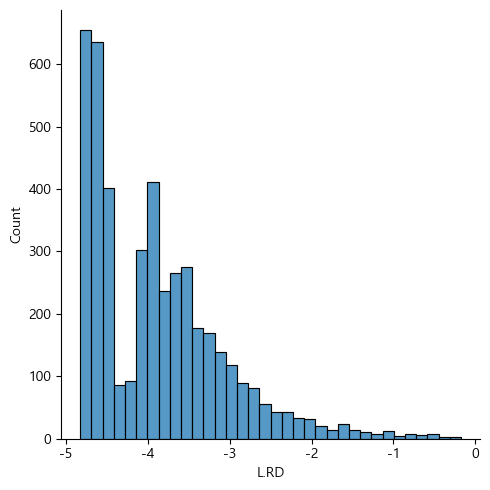

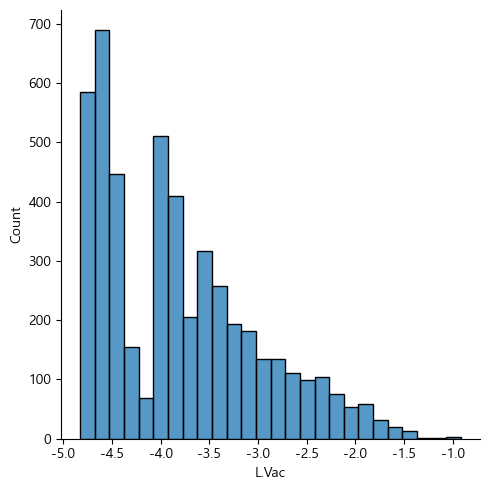

In [56]:
sns.displot(np.log(feat_extraction_df['L.RD']))
sns.displot(np.log(feat_extraction_df['L.Vac']))

In [57]:
# 타겟 간 상관계수

corr_target = feat_extraction_df['L.RD'].corr(feat_extraction_df['L.Vac'])
print("L.RD와 L.VAC 간의 상관계수:", corr_target)

# 0.2정도로 별도로 훈련

L.RD와 L.VAC 간의 상관계수: 0.19508106124792296


In [ ]:
# 이상치에 대한 임계값을 모르므로 DBSCAN활용
# eps : 너무 크면 하나의 클러스터로 묶일 수 있고 너무 작으면 클러스터가 너무 세분화됨

In [58]:
target_df = feat_extraction_df[['L.RD', 'L.Vac']]

In [65]:
# print(target_df['L.RD'].isnull().sum())

In [63]:
RD_threshold = np.percentile(feat_extraction_df['L.RD'], q= 87)
target_df['target_RD_defect'] = np.where(feat_extraction_df['L.RD'] >= RD_threshold, 1, 0)
target_df['target_RD_defect'].value_counts() # 7326, 1079

target_RD_defect
0    7064
1    1079
Name: count, dtype: int64

In [90]:
# 폐기율 데이터 (연속형 타겟)
target_RD = feat_extraction_df['L.RD'].values.reshape(-1, 1)  # 1차원 데이터를 2D 형태로 변환

# DBSCAN 적용
dbscan = DBSCAN(eps=0.008, min_samples= 1500) # 0.008보다 크면 오히려 이상치 줄어들고 0.007로 하면 클러스터가 늘어남
clusters = dbscan.fit_predict(target_RD)

np.unique(clusters)

# 결과를 데이터프레임에 추가
target_df = pd.DataFrame()
target_df['RD_cluster'] = clusters
print(target_df['RD_cluster'].value_counts())  # 각 클러스터별 데이터 수

RD_cluster
 0    7096
-1    1047
Name: count, dtype: int64


In [93]:
RD_outlier_idx = target_df[target_df['RD_cluster'] == -1].index
RD_outlier_values = feat_extraction_df.iloc[RD_outlier_idx]['L.RD'].values

print(np.max(RD_outlier_values))
print(np.min(RD_outlier_values)) # 이상치 중 가장 작은 값보다 크면 불량(폐기율이기 때문)

target_df['target_RD_defect'] = np.where(feat_extraction_df['L.RD'] >= np.min(RD_outlier_values), 1, 0)
target_df[['target_RD_defect']].value_counts()

0.841
0.034


target_RD_defect
0                   7096
1                   1047
Name: count, dtype: int64

In [95]:
# 폐기율 데이터 (연속형 타겟)
target_Vac = feat_extraction_df['L.Vac'].values.reshape(-1, 1)  # 1차원 데이터를 2D 형태로 변환

# DBSCAN 적용
dbscan = DBSCAN(eps= 0.008, min_samples= 1000) 
clusters = dbscan.fit_predict(target_Vac)

# 결과를 데이터프레임에 추가
target_df = pd.DataFrame()
target_df['Vac_cluster'] = clusters
print(target_df['Vac_cluster'].value_counts())  # 각 클러스터별 데이터 수


Vac_cluster
 0    7039
-1    1104
Name: count, dtype: int64


In [96]:
Vac_outlier_idx = target_df[target_df['Vac_cluster'] == -1].index
Vac_outlier_values = feat_extraction_df.iloc[Vac_outlier_idx]['L.Vac'].values

print(np.max(Vac_outlier_values))
print(np.min(Vac_outlier_values))

target_df['target_Vac_defect'] = np.where(feat_extraction_df['L.Vac'] >= np.min(Vac_outlier_values), 1, 0)
target_df[['target_Vac_defect']].value_counts()

0.4
0.039


target_Vac_defect
0                    7039
1                    1104
Name: count, dtype: int64

In [97]:
# preprocessing_df.info()
feat_extraction_df['RD_defect'] = np.where(feat_extraction_df['L.RD'] >= np.min(RD_outlier_values), 1, 0) # 1047개의 불량
feat_extraction_df['Vac_defect'] = np.where(feat_extraction_df['L.Vac'] >= np.min(Vac_outlier_values), 1, 0) # 1104개의 불량
# preprocessing_df.info()

analysis_df = feat_extraction_df.drop(['L.RD', 'L.Vac'], axis= 1)
RD_analysis_df = analysis_df.drop(['Vac_defect'], axis= 1)
Vac_analysis_df = analysis_df.drop(['RD_defect'], axis= 1)

RD_analysis_df.info() # (8143, 123)

<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 2016-01-01 07:00:00 to 2016-12-31 23:00:00
Columns: 123 entries, X1WOS45106_PV to RD_defect
dtypes: float64(119), int32(1), int64(3)
memory usage: 7.7+ MB


In [98]:
RD_total_df = RD_analysis_df.copy()
RD_total_df.to_csv('../data/RD_total_df.csv', header= True, index= True)

Vac_total_df = Vac_analysis_df.copy()
Vac_total_df.to_csv('../data/Vac_total_df.csv', header= True, index= True)

## 4. 타겟 2000개 샘플링(양품 : 1000개, 불량품 : 1000개) 

In [99]:
RD_analysis_df['RD_defect'].value_counts()[1]

1047

In [100]:
RD_normal_df = RD_analysis_df[RD_analysis_df['RD_defect'] == 0]
RD_defective_df = RD_analysis_df[RD_analysis_df['RD_defect'] == 1]
RD_normal_sample_df = RD_normal_df.sample(n= RD_analysis_df['RD_defect'].value_counts()[1], random_state= 42)
RD_sample_df = pd.concat([RD_normal_sample_df, RD_defective_df])
RD_sample_df.info()

RD_sample_df.to_csv('../data/RD_sample_df.csv', header= True, index= True)

<class 'pandas.core.frame.DataFrame'>
Index: 2094 entries, 2016-02-22 23:00:00 to 2016-12-31 01:00:00
Columns: 123 entries, X1WOS45106_PV to RD_defect
dtypes: float64(119), int32(1), int64(3)
memory usage: 2.0+ MB


In [101]:
Vac_normal_df = Vac_analysis_df[Vac_analysis_df['Vac_defect'] == 0]
Vac_defective_df = Vac_analysis_df[Vac_analysis_df['Vac_defect'] == 1]
Vac_normal_sample_df = Vac_normal_df.sample(n= Vac_analysis_df['Vac_defect'].value_counts()[1], random_state= 42)
Vac_sample_df = pd.concat([Vac_normal_sample_df, Vac_defective_df])
Vac_sample_df.info()

Vac_sample_df.to_csv('../data/Vac_sample_df.csv', header= True, index= True)

<class 'pandas.core.frame.DataFrame'>
Index: 2208 entries, 2016-04-13 18:00:00 to 2016-12-30 06:00:00
Columns: 123 entries, X1WOS45106_PV to Vac_defect
dtypes: float64(119), int32(1), int64(3)
memory usage: 2.1+ MB


In [104]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

RD_sample_df.describe()

,X1WOS45106_PV,X1WOS45109_PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,UPPER.AB1.Z1.TMP.1TIC41101.PV,UPPER.AB8.Z99.TMP.1TIC41801.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M5.1.CUR.1WII40106.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,TMP.GLASS..BAY.1.1TI30101.PV,X.1.BAY.LEFT.PRESSURE.1CLBAY1LEFT_CPV,X.7.BAY.RIGHT.PRESSURE.1CLBAY7RIGHT_CPV,X.1.LEHR.SO2.ANALYZER.1AI44110.PV,X.1.LEHR.O2.ANALYZER.1AI44111.PV,X.2.LEHR.SO2.ANALYZER.1AI44112.PV,X.2.LEHR.O2.ANALYZER.1AI44113.PV,N2.TO.EA1313B.1FI33527A_PV,N2.TO.HOOD.DOWN.STREAM.1FI33505A_PV,N2.TO.HOOD.UP.STREAM.1FI33506A_PV,LEHR.AB1.PRESS.1PI40302.PV,DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV,DB.BTM.UP.STM.TC.RC.1TI40402_PV,DB.BTM.UP.STM.TC.RE.1TI40403_PV,DB.HEAT.BOTTOM.1.1JIC40308.PV,DB.HEAT.BOTTOM.3.1JIC40310.PV,ROOF.HT.BAY.3.TOTAL.PWR.1CLBAY3_CPV,ROOF.HT.BAY.8.TOTAL.PWR.1CLBAY8_CPV,ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV,ROOF.HEATING.Zone.3.1JIC31103.PV.1,ROOF.HEATING.Zone.4.1JIC31104.PV.1,ROOF.HEATING.Zone.5.1JIC31105.PV,ROOF.HEATING.Zone.6.1JIC31106.PV,ROOF.HEATING.Zone12.1JIC31112.PV,ROOF.HEATING.Zone31.1JIC31131.PV,ROOF.HEATING.Zone39.1JIC31139.PV,ROOF.HEATING.Zone45.1JIC31145.PV,ROOF.HEATING.Zone49.1JIC31149.PV,ROOF.HEATING.Zone51.1JIC31151.PV,ROOF.HEATING.Zone53.1JIC31153.PV,ROOF.HEATING.Zone54.1JIC31154.PV,ROOF.HEATING.Zone55.1JIC31155.PV,ROOF.HEATING.Zone60.1JIC31160.PV,ROOF.HEATING.Zone63.1JIC31163.PV,ROOF.HEATING.Zone73.1JIC31173.PV,ROOF.HEATING.Zone77.1JIC31177.PV,ROOF.HEATING.Zone81.1JIC31181.PV,ATM.FLOW.SECT.2.N2.1FI33401.PV,ATM.FLOW.SECT.3.N2.1FI33403.PV,ATM.FLOW.SECT.4.N2.1FI33405.PV,SPOUT.LEFT.TOP.1FI33514.PV,SPOUT.RIGHT.BOTTOM.1FI33518.PV,ATM.N2.H2.5..함유율.1CLFI33402_CPV,ATM.N2.H2.9..함유율.1CLFI33406_CPV,LOR.1.L.Axis,LOR.1.L.Hori,LOR.2.L.Axis,LOR.3.L.Axis,LOR.3.L.Hori,LOR.1.R.Axis,LOR.1.R.Hori,LOR.2.R.Axis,LOR.2.R.Hori,LOR.3.R.Hori,r_tin_bay_5_7,lc_rc_btm_dn,le_re_btm_dn,l_r_top_n.1,top_5,D_AB1_U_LR,D_AB3_U_LR,D_AB5_L_LR,D_AB8_U_LR,D_AB9_U_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB2_R_UL,D_AB4_L_UL,D_AB6_R_UL,D_AB8_L_UL,D_C4_U_LR,D_C4_L_LR,D_C1_R_UL,D_C3_L_UL,D_GLS_AB7_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_R,S_AB2_AB3_U_L,S_AB7_AB8_U_L,S_AB8_AB9_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C2_C3_L_L,투입.LEFT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,폐기율...,bgm_predict_proba_0,bgm_predict_proba_1,bgm_predict_proba_2,bgm_predict_proba_3,bgm_predict_proba_4,RD_defect
count,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2.094000e+03,2.094000e+03,2094.000000,2.094000e+03,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2.094000e+03,2094.000000,2.094000e+03,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.0000

In [ ]:
# 머신러닝 10개의 피쳐를 가진 예측 문제에서 선형 회귀 모델을 학습하려면 100~500개의 데이터 필요
# 딥러닝 10개의 클래스를 분류하는 CNN모델의 경우 클래스당 1000개 이상 필요

# 현재 94개의 피쳐 : 최소 1000~5000개의 데이터 필요

# 해결 방법
# 1) 언더샘플링 - 무작위 샘플링하여 데이터 비율 맞추는 방법(데이터 손실 주의)
# 2) 오버샘플링 - 소수 클래스를 중복 생성하여 비율 맞추는 방법(과적합 주의)
# 3) 차원 축소
# 4) 클래스 가중치 조정 - 소수 클래스에 더 큰 가중치 부여 : sklearn의 class_weight 매개변수
# 5) 앙상블 모델 - 여러 모델을 조합하여 성능을 내는 방법 - 랜덤 포레스트나 배깅과 같은 앙상블 기법

# 평가 지표 선택
# 불균형 데이터의 경우 정확도만으로 성능 평가가 어려움
# 정밀도, 재현율, F1 점수, AUC-ROC

# 랜덤 포레스트/XGBoost와 같은 머신 러닝 모델 시도
# 충분한 성능을 얻지 못한다면 데이터 증강 및 오버 샘플링을 사용하여 딥러닝 모델 시도